In [59]:
import pandas as pd
from collections import defaultdict
from obspy import UTCDateTime
import numpy as np
from bisect import bisect_left
from pathlib import Path
import torch
import obspy

In [28]:
split_info=torch.load("/mnt/home/xiziyi/Packages_Research/PhaseNet-TF/workplace/split_pairs.pt")

In [29]:
split_info

{'train_pairs': [('1_52260', 'CICA'),
  ('22_52535', 'C02'),
  ('2_52228', 'S02W'),
  ('4_55311', 'B12'),
  ('2_52297', 'N03W'),
  ('4_55406', 'NMKA'),
  ('1_51965', 'A11'),
  ('11_52234', 'S02W'),
  ('11_52336', 'EUAP'),
  ('2_52151', 'B06'),
  ('3_52658', 'A08W'),
  ('4_55441', 'A03'),
  ('1_52158', 'A03'),
  ('1_52152', 'F02W'),
  ('3_52154', 'C15'),
  ('2_52329', 'TNGA'),
  ('22_52630', 'C02'),
  ('3_52492', 'A10W'),
  ('4_54752', 'PNGI'),
  ('4_54752', 'B06'),
  ('2_52421', 'FONI'),
  ('3_53818', 'NMKA'),
  ('3_53598', 'A01'),
  ('2_52599', 'TNGA'),
  ('1_51923', 'NADI'),
  ('1_51874', 'TNGA'),
  ('4_54579', 'NMKA'),
  ('1_51864', 'FOA'),
  ('4_54537', 'N02W'),
  ('2_52215', 'C13'),
  ('1_52249', 'MOAL'),
  ('4_55428', 'VAVP'),
  ('2_52245', 'B06'),
  ('4_55466', 'LKBA'),
  ('3_52343', 'PNGI'),
  ('4_54516', 'FOA'),
  ('2_52266', 'VAVP'),
  ('1_52225', 'A01'),
  ('1_51885', 'CICA'),
  ('2_52107', 'A05'),
  ('1_51958', 'A10W'),
  ('3_53719', 'B03'),
  ('1_51903', 'A14W'),
  ('3_524

In [9]:
old_path="/mnt/home/xiziyi/Packages_Research/PhaseNet-TF/dataset/phase_picks.csv"
old=pd.read_csv(old_path)
# map station_id to sta, phase_time to time, phase_type to phase
old=old.rename(columns={"station_id":"sta","phase_time":"time","phase_type":"phase"})

In [31]:
# if old's (event_id,sta) is in split_info["test_pairs"], then it's test set and write to old_test
old_test=old[old.apply(lambda x: (x["event_id"],x["sta"]) in split_info["test_pairs"],axis=1)]

In [14]:
new_paths=[f"/mnt/scratch/xiziyi/inference/new_20230509/train_bench_0_1/phase_arrivals_{i}.csv" for i in range(4)]
new_dfs=[pd.read_csv(new_path,skiprows=1,usecols=[0,1,4,5,6,7],names=["net","sta","phase","offset","time","score"]) for new_path in new_paths]
new=pd.concat(new_dfs)

In [32]:
len(old),len(new),len(old_test)

(60307, 402197, 3017)

In [33]:
def update_cache(cache, row):
    cache[row.sta][row.phase].append(UTCDateTime(row.time))

def sort_cache(cache):
    for sta in cache:
        for phase in cache[sta]:
            cache[sta][phase].sort()

old_cache = defaultdict(lambda: defaultdict(list))
new_cache = defaultdict(lambda: defaultdict(list))
old_test_cache = defaultdict(lambda: defaultdict(list))

old.apply(lambda row: update_cache(old_cache, row), axis=1)
new.apply(lambda row: update_cache(new_cache, row), axis=1)
old_test.apply(lambda row: update_cache(old_test_cache, row), axis=1)

sort_cache(old_cache)
sort_cache(new_cache)
sort_cache(old_test_cache)

In [19]:
def get_confusion_matrix(sta,phase,real,predict,threshold):
    # * now we use the binary search
    # for each real, search in predict
    tp,fn=0,0
    for each in real:
        pos=bisect_left(predict,each)
        case1=False
        if pos>0:
            case1=np.abs(predict[pos-1]-each)<=threshold
        case2=False
        if pos<len(predict):
            case2=np.abs(predict[pos]-each)<=threshold
        if case1 or case2:
            tp+=1
        else:
            fn+=1

    # for each predict, search in real
    tp_recalculate,fp=0,0
    for each in predict:
        pos=bisect_left(real,each)
        case1=False
        if pos>0:
            case1=np.abs(real[pos-1]-each)<=threshold
        case2=False
        if pos<len(real):
            case2=np.abs(real[pos]-each)<=threshold
        if case1 or case2:
            tp_recalculate+=1
        else:
            fp+=1
    try:
        assert tp==tp_recalculate
    except:
        print(f"{sta} {phase} {tp} {tp_recalculate}")
    return tp,fn,fp

In [20]:
threshold=2

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_cache:
    for phase in old_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

A06W S 145 144
A08W S 71 70
A09 S 105 104
A11 S 139 138


(defaultdict(int, {'P': 40866, 'S': 12879, 'PS': 0}),
 defaultdict(int, {'P': 383, 'S': 1055, 'PS': 5124}),
 defaultdict(int, {'P': 233086, 'S': 115313, 'PS': 0}))

In [34]:
threshold=2

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 2046, 'S': 650, 'PS': 0}),
 defaultdict(int, {'P': 17, 'S': 47, 'PS': 257}),
 defaultdict(int, {'P': 271852, 'S': 125718, 'PS': 0}))

In [21]:
threshold=1.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_cache:
    for phase in old_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

A06W S 141 140
A08W S 71 70
A09 S 104 103
A11 S 136 135


(defaultdict(int, {'P': 40767, 'S': 12728, 'PS': 0}),
 defaultdict(int, {'P': 482, 'S': 1206, 'PS': 5124}),
 defaultdict(int, {'P': 233185, 'S': 115464, 'PS': 0}))

In [35]:
threshold=1.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 2044, 'S': 644, 'PS': 0}),
 defaultdict(int, {'P': 19, 'S': 53, 'PS': 257}),
 defaultdict(int, {'P': 271854, 'S': 125724, 'PS': 0}))

In [22]:
threshold=1.0

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_cache:
    for phase in old_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

A08W S 69 68
A09 S 98 97
A11 S 130 129


(defaultdict(int, {'P': 40548, 'S': 12351, 'PS': 0}),
 defaultdict(int, {'P': 701, 'S': 1583, 'PS': 5124}),
 defaultdict(int, {'P': 233404, 'S': 115840, 'PS': 0}))

In [36]:
threshold=1.0

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 2028, 'S': 623, 'PS': 0}),
 defaultdict(int, {'P': 35, 'S': 74, 'PS': 257}),
 defaultdict(int, {'P': 271870, 'S': 125745, 'PS': 0}))

In [24]:
threshold=0.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_cache:
    for phase in old_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

A08W S 55 54
A09 S 69 68
A11 S 108 107


(defaultdict(int, {'P': 39850, 'S': 10995, 'PS': 0}),
 defaultdict(int, {'P': 1399, 'S': 2939, 'PS': 5124}),
 defaultdict(int, {'P': 234102, 'S': 117196, 'PS': 0}))

In [37]:
threshold=0.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 1994, 'S': 563, 'PS': 0}),
 defaultdict(int, {'P': 69, 'S': 134, 'PS': 257}),
 defaultdict(int, {'P': 271904, 'S': 125805, 'PS': 0}))

In [40]:
confusion_matrix_with_problems=[]
def get_confusion_matrix_with_problems(sta,phase,real,predict,threshold):
    # * now we use the binary search
    # for each real, search in predict
    tp,fn=0,0
    for each in real:
        pos=bisect_left(predict,each)
        case1=False
        if pos>0:
            case1=np.abs(predict[pos-1]-each)<=threshold
        case2=False
        if pos<len(predict):
            case2=np.abs(predict[pos]-each)<=threshold
        if case1 or case2:
            tp+=1
        else:
            fn+=1
            if phase=="S":
                confusion_matrix_with_problems.append((sta,each,predict[pos-1] if pos>0 else None,predict[pos] if pos<len(predict) else None))

    # for each predict, search in real
    tp_recalculate,fp=0,0
    for each in predict:
        pos=bisect_left(real,each)
        case1=False
        if pos>0:
            case1=np.abs(real[pos-1]-each)<=threshold
        case2=False
        if pos<len(real):
            case2=np.abs(real[pos]-each)<=threshold
        if case1 or case2:
            tp_recalculate+=1
        else:
            fp+=1
    try:
        assert tp==tp_recalculate
    except:
        print(f"{sta} {phase} {tp} {tp_recalculate}")
    return tp,fn,fp

In [41]:
threshold=0.5

tp,fn,fp=defaultdict(int),defaultdict(int),defaultdict(int)
for sta in old_test_cache:
    for phase in old_test_cache[sta]:
        x,y,z=get_confusion_matrix_with_problems(sta,phase,old_test_cache[sta][phase],new_cache[sta][phase],threshold)
        # print(x,y,z)
        tp[phase]+=x
        fn[phase]+=y
        fp[phase]+=z
tp,fn,fp

(defaultdict(int, {'P': 1994, 'S': 563, 'PS': 0}),
 defaultdict(int, {'P': 69, 'S': 134, 'PS': 257}),
 defaultdict(int, {'P': 271904, 'S': 125805, 'PS': 0}))

In [67]:
confusion_matrix_with_problems.sort()
confusion_matrix_with_problems

[('A01',
  2010-02-07T23:25:25.888620Z,
  2010-02-07T22:32:25.426000Z,
  2010-02-07T23:25:27.836000Z),
 ('A01',
  2010-02-19T19:57:33.575900Z,
  2010-02-19T17:49:38.524000Z,
  2010-02-20T12:26:04.294000Z),
 ('A01',
  2010-08-15T02:53:45.714730Z,
  2010-08-14T20:47:01.896000Z,
  2010-08-15T02:53:46.259000Z),
 ('A02W',
  2009-12-16T15:19:26.653140Z,
  2009-12-16T15:13:04.300800Z,
  2009-12-16T16:35:29.430800Z),
 ('A02W',
  2009-12-25T20:43:09.215900Z,
  2009-12-25T04:17:05.896100Z,
  2009-12-25T23:36:54.646100Z),
 ('A02W',
  2010-08-04T15:56:34.405520Z,
  2010-08-04T15:56:33.622600Z,
  2010-08-04T20:00:37.622600Z),
 ('A03',
  2010-05-25T01:31:01.066507Z,
  2010-05-25T01:31:00.150000Z,
  2010-05-25T02:25:16.200000Z),
 ('A03',
  2010-07-17T14:52:31.542430Z,
  2010-07-17T14:23:20.759000Z,
  2010-07-17T14:52:32.309000Z),
 ('A03',
  2010-09-20T14:47:46.600140Z,
  2010-09-20T14:47:45.522000Z,
  2010-09-20T14:48:04.592000Z),
 ('A05',
  2010-04-12T05:10:14.235180Z,
  2010-04-12T05:10:13.234000Z,

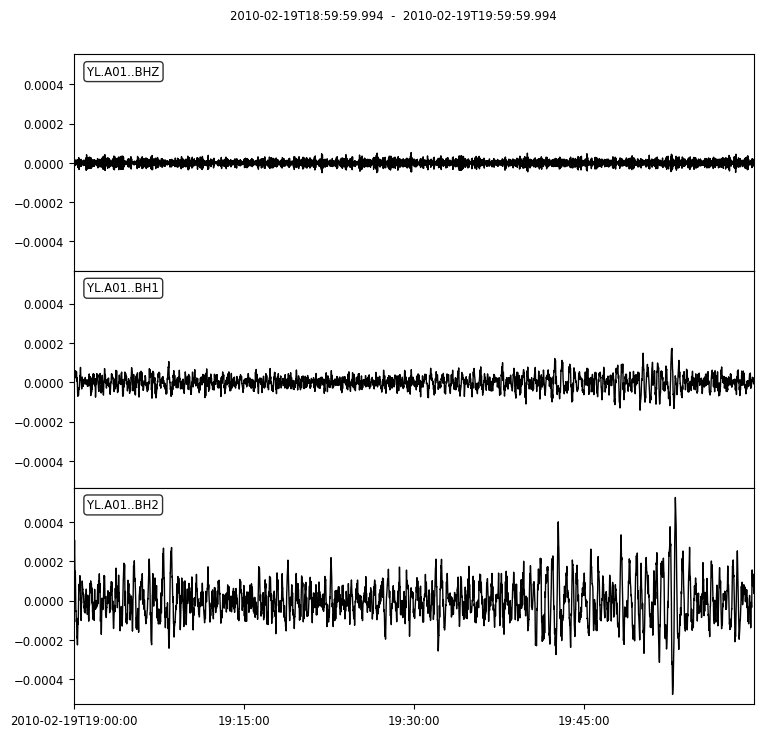

In [65]:
# let's plot the waveform to see what's the problem for these cases
obspy.read("/mnt/scratch/xiziyi/inference/new_20230509/train_bench_0_1/YL.A01.2010-02-19T19:00:00.000000Z.2010-02-19T20:00:00.000000Z.waveform.mseed").plot();

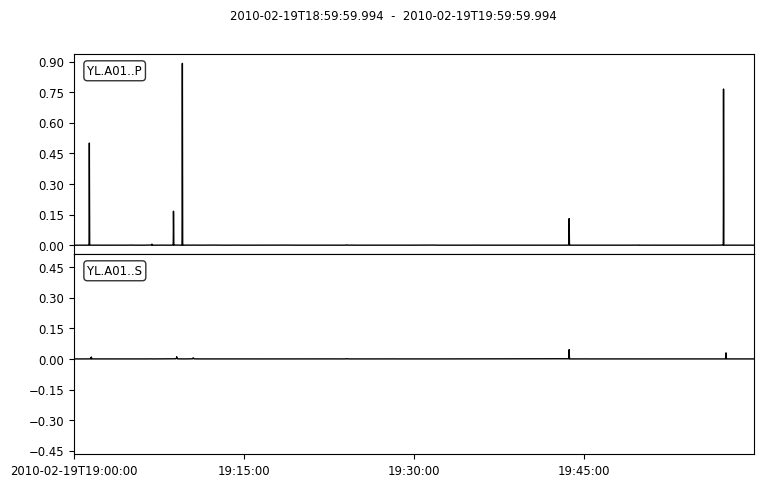

In [66]:
# let's plot the waveform to see what's the problem for these cases
obspy.read("/mnt/scratch/xiziyi/inference/new_20230509/train_bench_0_1/YL.A01.2010-02-19T19:00:00.000000Z.2010-02-19T20:00:00.000000Z.prediction.mseed").plot();